# Modelling Bank Churn data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This Notebook explores and models the Bank Churn dataset. It is available in [Kaggle](https://www.kaggle.com/shrutimechlearn/churn-modelling) and was studied by [Amit Chauhan](https://pub.towardsai.net/bank-churn-modeling-with-neural-networks-31881eee6112). He employs `KerasClassifier` to find the best Neural Net, capable to predict if a client is going to close his/her bank account or not. 

The work below follows the same approach but extends it to improve predictions. Bank Churn data contains details of a bank's customers (e.g., age, gender, issued credit card, balance, etc.); the target ("Exited") is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer. The dataset has only 10000 entries and for this reason predictions were made with ensemble algorithms instead with a Neural Network, which would be suitable for a much larger dataset. 

### Imports

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score, confusion_matrix, classification_report

In [5]:
import tensorflow as tf

In [6]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.activations import relu, sigmoid

## I. Load Bank Churn Dataset

The dataset was loaded and stored in `bank_data`. Its head rows are displayed below.

In [7]:
bank_data = pd.read_csv("/content/drive/MyDrive/small_tasks/Churn_Modelling.csv")

In [8]:
bank_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## II. Exploratory Data Analysis

In [9]:
bank_data.shape

(10000, 14)

The dataset has 10000 rows (unique entries for each client) and 14 columns. The latter hold information about clients' ID in the bank, surname, credit score, place of residence, gender and age, type of tenure, account balance, number of products used, if the account is associated with a credit card or not, if the client is an active member, estimated salary, and if he or she has closed the account.

The check below shows that there are not missing values. Some columns hold numeric (int64 or float64) values, whereas others - strings (e.g., place of residence, gender, etc.)

In [10]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Bank's clients reside in only three countries - France, Spain, and Germany.

In [11]:
bank_data["Geography"].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

The Bank offered to its clients only four products but there is not information as what these products were. 

In [12]:
bank_data["NumOfProducts"].unique()

array([1, 3, 2, 4])

It is important to get insight into the values and their range in each feature (column). Therefore, the next code lines plots distributions and counts for each variable. Computations were wrapped in a function to speed up and simplify the analysis.

In [13]:
def plot_distribution(column):
    """
    Function: displays distribution of continuous variables; computes mean 
      and median values.
    
    Parameters: feature placed inside quotation marks.
    
    Returns: distribution plot.
    """
    mean = bank_data[column].mean()
    median = bank_data[column].median()

    plt.hist(bank_data[column], bins = 15)
    plt.axvline(mean, color = "r", linestyle = "--")
    plt.axvline(median, color = "y", linestyle = "-")
    
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.title(f"Distribution of {column}")
    plt.show()

Credit scores range between 350 and 850 poits. Most clients were scored around 650. Both the mean and the median are around this figure. Values are almost normally distributed.

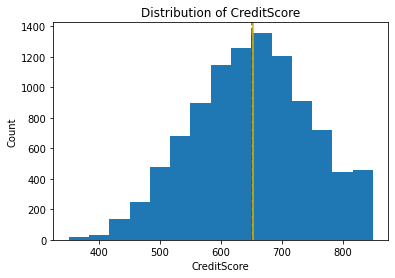

In [14]:
plot_distribution("CreditScore")

Most Bank customers are young people. Their mean age is slightly below 40 years of age. Data distribution is skewed on the right, i.e., the right tail is much longer than the left tail. This pushes the median to the left, away from the mean.

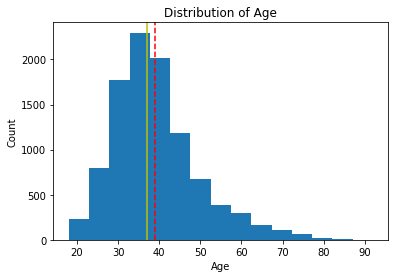

In [15]:
plot_distribution("Age")

If there were not people with zero balance, the remaining values would have been normally distributed. However, as high as 36% of customers had no money in their account.

In [16]:
bank_data[bank_data["Balance"] == 0]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.0,1,1,1,101348.88,1
3,4,15701354,Boni,699,France,Female,39,1,0.0,2,0,0,93826.63,0
6,7,15592531,Bartlett,822,France,Male,50,7,0.0,2,1,1,10062.80,0
11,12,15737173,Andrews,497,Spain,Male,24,3,0.0,2,1,0,76390.01,0
12,13,15632264,Kay,476,France,Female,34,10,0.0,2,1,0,26260.98,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,15605622,McMillan,841,Spain,Male,28,4,0.0,2,1,1,179436.60,0
9992,9993,15657105,Chukwualuka,726,Spain,Male,36,2,0.0,1,1,0,195192.40,0
9994,9995,15719294,Wood,800,France,Female,29,2,0.0,2,0,0,167773.55,0
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.0,2,1,0,96270.64,0


For this reason, both the mean and the median are pulled to the left. Most clients with positive balance on their account had between 50000 and 200000 currency units (e.g., USD, Euros, etc.).

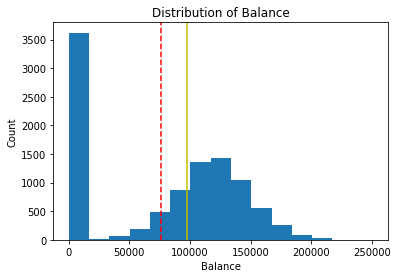

In [17]:
plot_distribution("Balance")

In terms of income, there is not a prevailing amount in the data. Values in Estimated Salary are distributed uniformly between 0 and 200000 currency units. Both the mean and the median are around 100000.

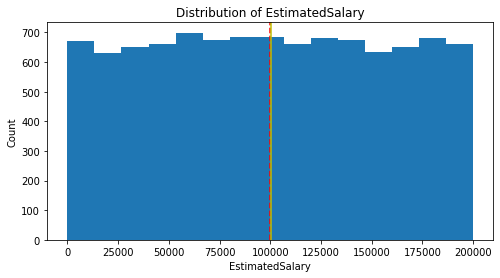

In [18]:
plt.figure(figsize = (8, 4))
plot_distribution("EstimatedSalary")

In [19]:
def plot_counts(column):
    """
    Function: displays counts of discrete variables (categories)
    
    Parameters: feature placed inside quotation marks.
    
    Returns: count plot.
    """
    bank_data[column].value_counts().plot(kind = "bar")
    plt.xticks(rotation = 0)
    plt.ylabel("Count")
    plt.title(f"Count of each category in {column}")
    plt.show()

Most Bank's customers reside in France. Almost equal number live either in Germany or in Spain.

In [20]:
Counter(bank_data["Geography"])

Counter({'France': 5014, 'Germany': 2509, 'Spain': 2477})

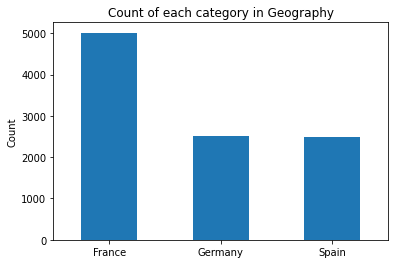

In [21]:
plot_counts("Geography")

It seems that slightly more men than women have a bank account in the analysed institution.

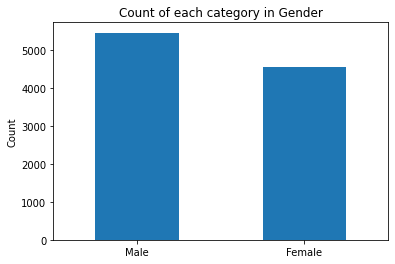

In [22]:
plot_counts("Gender")

Tenure referes to the minimum time for keeping the money with the bank. It is not clear from the data source what exactly stands behind "Tenure" categories. Nonetheless, the plot below shows that each period had amlost equal number of clients save those that chose "10" or "0".

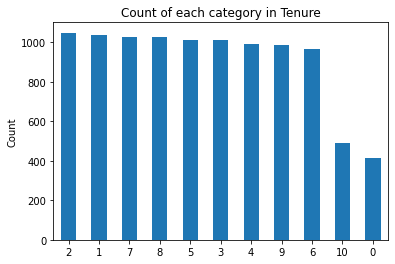

In [23]:
plot_counts("Tenure")

There is not clarification as to the type of products used by the clients either. Most of them used products of type "1" or "2". Only a tiny number of customers chose products "3" and "4".

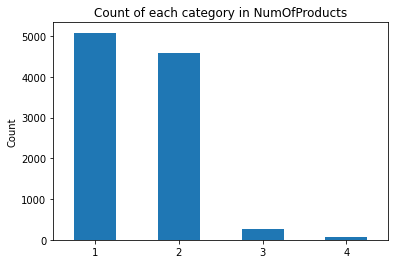

In [24]:
plot_counts("NumOfProducts")

Some colums, including the target one (the one holding the labels), have only "1" and "0" values. Following the [Boolean data type convention](https://en.wikipedia.org/wiki/Boolean_data_type), it is assumed that "1" stands for "Yes" / "True", and "0" - for "No" / "False". Thus, it could be concluded that around 70% of account owners have a credit card associated with it.

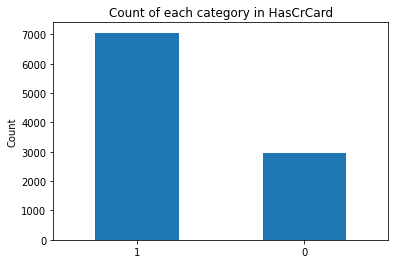

In [25]:
plot_counts("HasCrCard")

It is not clear what "an active member" exactly means, too. It could be assumed that a client is an active member if he or she regularly (e.g., at least 2 - 3 time a month) makes transactions. Hence, the data show that half of the customers were active, and the remaining half were not.

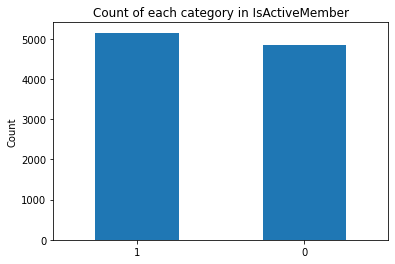

In [26]:
plot_counts("IsActiveMember")

The target (label) column "Exited" shows if a customer has closed his or her account or not. The plot below suggests most people remained clients of the analysed bank.

In [27]:
Counter(bank_data["Exited"])

Counter({0: 7963, 1: 2037})

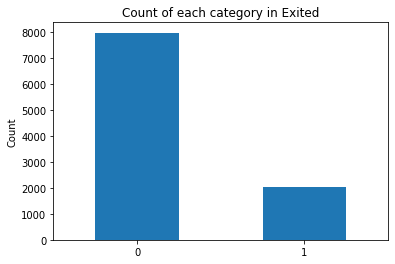

In [28]:
plot_counts("Exited")

The plot below shows that clients that closed their account reside predominantly in Germany and France.

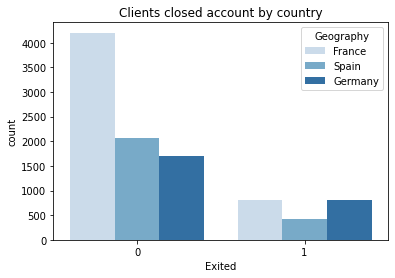

In [29]:
fig, ax = plt.subplots(figsize = (6, 4)) 
sns.countplot(data = bank_data, x = "Exited", hue = "Geography", palette = "Blues")
ax.set(title = "Clients closed account by country", ylabel = "count")
plt.show()

Being an active member could suggest the outcome: less transactions might indicate a client is likely to leave the bank.

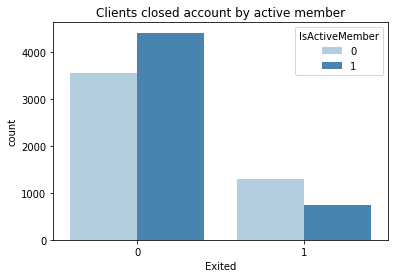

In [30]:
fig, ax = plt.subplots(figsize = (6, 4)) 
sns.countplot(data = bank_data, x = "Exited", hue = "IsActiveMember", palette = "Blues")
ax.set(title = "Clients closed account by active member", ylabel = "count")
plt.show()

#### Clean the dataset

"RowNumber" column has 10000 unique values, i.e., for each entry. Thus, it does not hold useful information. Instead of dropping, it is set for index.

In [31]:
len(bank_data["RowNumber"].unique())

10000

In [32]:
bank_data.set_index("RowNumber", inplace = True)

In [33]:
bank_data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


"CustomerId" and "Surname" are not good predictors either due to their high entropy. For this reason, both are removed from the dataset.

In [34]:
len(bank_data["CustomerId"].unique())

10000

In [35]:
bank_data = bank_data.drop(["CustomerId", "Surname"], axis = 1)

In [36]:
bank_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### Data statistics

The code line below displays the main statistics for all numeric fields.

In [37]:
bank_data.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


Outliers and data groupings are best visible on box plots. To display them, all numeric columns are placed in another variable (`bank_data_numeric`).

In [38]:
bank_data_numeric = bank_data[["CreditScore", "Age", "Tenure", "Balance",
                               "NumOfProducts", "HasCrCard", "IsActiveMember",
                               "EstimatedSalary", "Exited"]]

It could be seen that clients with credit score below 400 are considered outliers. People aged over 60 years are also deemed outliers. Extreme values are not found in "Tenure", "Balance", "HasCrCard", "IsActiveMember", and "EstimatedSalary". Those who left the bank are categorised as outliers (perhaps because of their insignificant number).

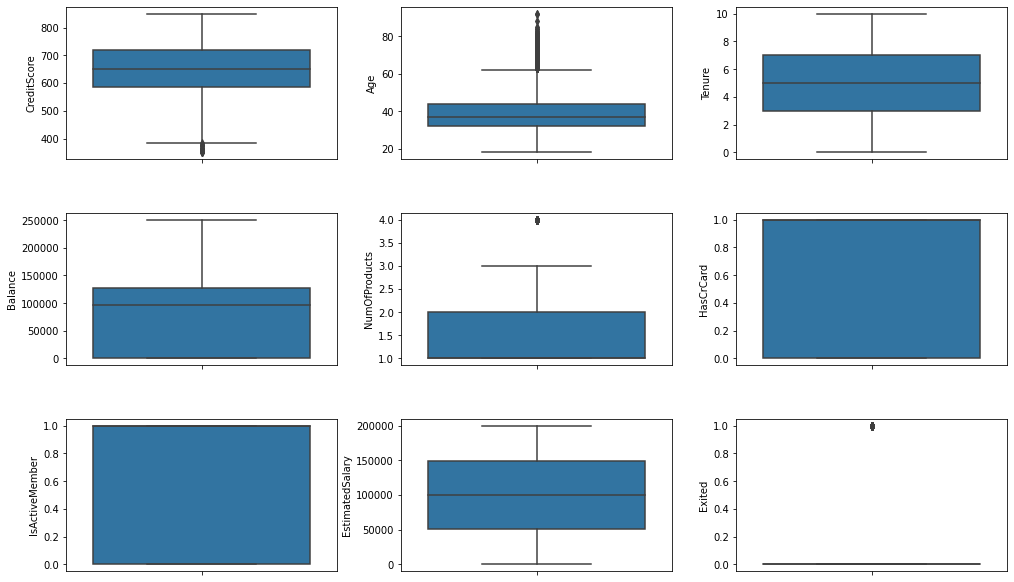

In [39]:
fig, axs = plt.subplots(ncols = 3, nrows = 3, figsize = (14, 8))
idx = 0
axs = axs.flatten()
for k, v in bank_data_numeric.items():
    sns.boxplot(y = k, data = bank_data_numeric, ax = axs[idx])
    idx += 1
plt.tight_layout(pad = 0.4, w_pad = 0.5, h_pad = 5.0)

#### Correlation

It is nice to see that there is almost none correlation between data features. Thus, if there is any relationship between features and target variable, it most likely would be non-linear one. Only "Age" is more or less positively correlated with "Exited", which means getting older might impact a decision to stay or not with the bank.

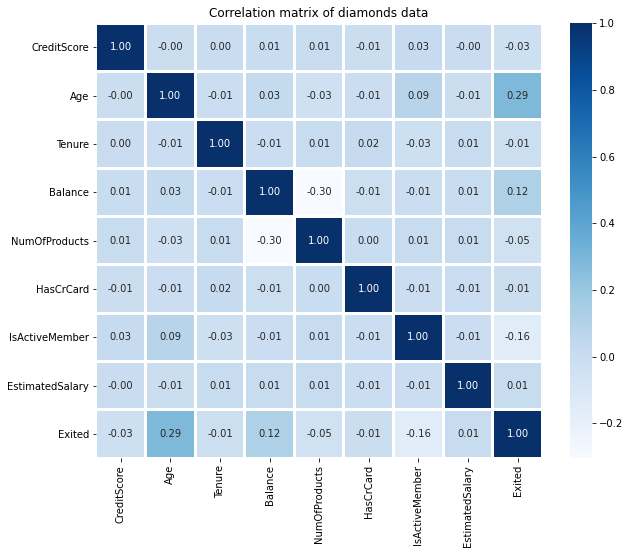

In [40]:
plt.figure(figsize = (10, 8))
sns.heatmap(bank_data_numeric.corr(),
           annot = True,
           cmap = "Blues",
           fmt = ".2f",
           linewidths = 2, 
           linecolor = "white")
plt.title("Correlation matrix of diamonds data")
plt.show()

## III. Data pre-processing

### 1. Make all values numeric

Machine Learning algorithms expect matrices of numeric values. The `bank_data` contains both numeric and text values. The latter should be turned into numbers. Pandas `get_dummies()` will do the job - it converts (one hot encodes) the two columns ("Geography" and "Gender") and makes them numeric.

In [41]:
bank_data = pd.get_dummies(bank_data)

In [42]:
bank_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
RowNumber,,,,,,,,,,,,,,
1,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
2,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
3,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
4,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
5,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


All data are of numeric type now. Later, all will be converted into floating point numbers.

In [43]:
bank_data.dtypes

CreditScore            int64
Age                    int64
Tenure                 int64
Balance              float64
NumOfProducts          int64
HasCrCard              int64
IsActiveMember         int64
EstimatedSalary      float64
Exited                 int64
Geography_France       uint8
Geography_Germany      uint8
Geography_Spain        uint8
Gender_Female          uint8
Gender_Male            uint8
dtype: object

### 2. Separate features and labels

Features are separated from labels for further pre-processing. 

In [44]:
bank_features = bank_data.drop("Exited", axis = 1)
bank_labels = bank_data["Exited"]

Features' titles are printed since will be needed later.

In [45]:
bank_features.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_France',
       'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male'],
      dtype='object')

### 3. Scale feature values

Feature values are normalized, i.e., they are constrained within a given range, and turned into "float32" type (which is prefered for data fed to Machine Learning algorithms). In this particular case, all values are made between 0 and 1. The function below performs "min-max-scaling" (to avoid using sklearn's `MinMaxScaler()`).

In [46]:
def min_max_scaler(features):
    """
    Function: scales values between 0 and 1.
    
    Parameters: dataset as an NumPy array.
    
    Returns: scaled NumPy array in float32 dtype.
    """
    max_n = np.max(features)
    min_n = np.min(features)
    scaled_features = np.array([(x - min_n) / (max_n - min_n) for x in features])
    return scaled_features.astype("float32")

In [47]:
bank_features_scaled = min_max_scaler(bank_features.values)

In [48]:
bank_features_scaled.min(), bank_features_scaled.max()

(0.0, 1.0)

Scaled data are placed in Pandas `DataFrame` for easier visualization. Features' titles should be specified again.

In [49]:
bank_features_scaled = pd.DataFrame(bank_features_scaled)

In [50]:
bank_features_scaled.columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 
                                'NumOfProducts', 'HasCrCard', 'IsActiveMember', 
                                'EstimatedSalary', 'Geography_France', 
                                'Geography_Germany', 'Geography_Spain', 
                                'Gender_Female', 'Gender_Male']

The first five rows with scaled values are displayed below.

In [51]:
bank_features_scaled.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.002467,0.000167,0.000008,0.000000,0.000004,0.000004,0.000004,0.403944,0.000004,0.0,0.000000,0.000004,0.0
1,0.002423,0.000163,0.000004,0.334031,0.000004,0.000000,0.000004,0.448559,0.000000,0.0,0.000004,0.000004,0.0
2,0.002001,0.000167,0.000032,0.636357,0.000012,0.000004,0.000000,0.454095,0.000004,0.0,0.000000,0.000004,0.0
3,0.002786,0.000155,0.000004,0.000000,0.000008,0.000000,0.000000,0.373963,0.000004,0.0,0.000000,0.000004,0.0
4,0.003388,0.000171,0.000008,0.500246,0.000004,0.000004,0.000004,0.315204,0.000000,0.0,0.000004,0.000004,0.0


To confirm the scaled data holds the same information, the code lines below ask for displaying the distribution in the "Balance" column. It is identical to the one produced with the unscaled data.

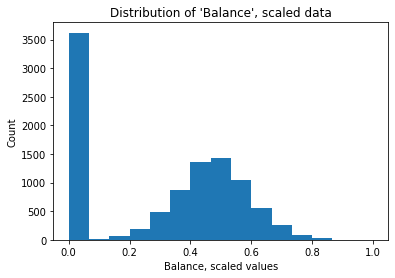

In [52]:
plt.hist(bank_features_scaled["Balance"], bins = 15)
plt.xlabel("Balance, scaled values")
plt.ylabel("Count")
plt.title("Distribution of 'Balance', scaled data")
plt.show()

### 4. Split data into train and test sets

At the end, the dataset is split into train and test sets. Cross-validation technique is used instead of withholding validation set due to the small number of samples. The latter is a reason for taking out only 20% for testing. In general, it is better to show more examples to the algorithm; thus, it will be able to learn more and diverse relationships. By default, `train_test_split` shuffles the data. Providing a variable for stratifying helps for getting train and test data with similar distribution. 

In [53]:
bank_features_train, bank_features_test, bank_labels_train, bank_labels_test = train_test_split(
        bank_features_scaled, bank_labels, test_size = 0.2,
        stratify = bank_labels, random_state = 42)

The code line below confirms the splitting was properly done. The plots thereafter display distribution of labels in both training and testing sets.

In [54]:
bank_features_train.shape, bank_labels_train.shape, bank_features_test.shape, bank_labels_test.shape

((8000, 13), (8000,), (2000, 13), (2000,))

In [55]:
def count_classes(labels, title = None):
    """
    Function: Counts items in each category (class).
    
    Parameters: Labels (y).
    
    Returns: Displays number of items in each category (class).
    """
    sns.countplot(x = labels, data = labels)
    if title is not None:
      plt.title(title)
    plt.show()

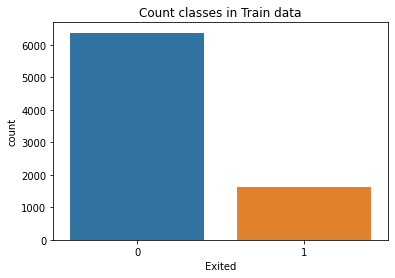

In [56]:
count_classes(bank_labels_train, "Count classes in Train data")

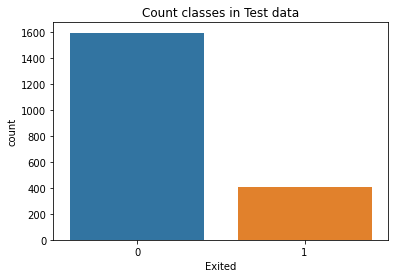

In [57]:
count_classes(bank_labels_test, "Count classes in Test data")

## IV. Build and Train Neural Network

The function below builds a Neural Network with Dense layers. The latter's number and the type of activation are it's parameters. Gradient Descent is computed with Adam optimizer. "binary crossentropy" computes the loss function; model's success is measured in terms of "accuracy". The model is created by empoying `KerasClassifier()`. The latter is a `Keras` scikit-learn wrapper that enables including K-fold cross validation in a Keras code.

In [58]:
def create_model(layers, activation):
    """
    Function: Builds and compiles a model.
    
    Parameters: Number of layers and type of activation.
    
    Returns: Built and compiled model.
    """
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i == 0:
            model.add(Dense(nodes, input_dim = bank_features_train.shape[1]))
            model.add(Activation(activation))
        else:
            model.add(Dense(nodes))
            model.add(Activation(activation))
    model.add(Dense(1))

    model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
    
    return model

In [59]:
model = KerasClassifier(build_fn = create_model)

Layers and their nodes, as well as the type of activation, are hyper-parameters. A range of their respective values are stored in variables, which in turn are placed in a dictionary for Grid Search.

In [60]:
layers = [[15], [35, 25], [40, 25, 15]]

In [61]:
activations = ["sigmoid", "relu"]

In [62]:
param_grid = dict(layers = layers, activation = activations,
                  batch_size = [128, 256], epochs = [30])

`GridSearchCV()` looks into all combinations and tries to find the one returning the lowest loss and highest accuracy. It gets training features and labels.

In [63]:
grid = GridSearchCV(estimator = model, param_grid = param_grid)

In [64]:
grid_result = grid.fit(bank_features_train.values, bank_labels_train.values)

Epoch 1/30
50/50 [==============================] - 1s 2ms/step - loss: 3.0802 - accuracy: 0.8003
Epoch 2/30
50/50 [==============================] - 0s 2ms/step - loss: 3.0802 - accuracy: 0.8003
Epoch 3/30
50/50 [==============================] - 0s 2ms/step - loss: 3.0802 - accuracy: 0.8003
Epoch 4/30
50/50 [==============================] - 0s 2ms/step - loss: 3.0802 - accuracy: 0.8003
Epoch 5/30
50/50 [==============================] - 0s 2ms/step - loss: 3.0802 - accuracy: 0.8003
Epoch 6/30
50/50 [==============================] - 0s 2ms/step - loss: 3.0802 - accuracy: 0.8003
Epoch 7/30
50/50 [==============================] - 0s 2ms/step - loss: 3.0802 - accuracy: 0.8003
Epoch 8/30
50/50 [==============================] - 0s 2ms/step - loss: 3.0802 - accuracy: 0.8003
Epoch 9/30
50/50 [==============================] - 0s 2ms/step - loss: 3.0802 - accuracy: 0.8003
Epoch 10/30
50/50 [==============================] - 0s 2ms/step - loss: 3.0802 - accuracy: 0.8003
Epoch 11/30
50/50 [

Applying `best_score_` and `best_params_` over the grid-searched object returns the best combination of hyper-parameters and the accuracy they reached. The output below shows that a model with a Dense layer with 15 nodes, with "sigmoid" activation, trained on a batches of 128 samples for 30 epochs attained accuracy of almost 80%.

In [65]:
grid_result.best_score_, grid_result.best_params_

(0.7962499976158142,
 {'activation': 'sigmoid', 'batch_size': 128, 'epochs': 30, 'layers': [15]})

#### Model evaluation

A classification model's performance is usually evaluated in terms of its accuracy, precision, recall, and f1 score (all classification metrics). These are returned by `classification_report`, `accuracy_score`, etc. The `confusion_matrix` displays properly and wrongly predicted samples. Some of these functions need predicted values on the testing data. Therefore, these are computed and stored in `pred`.

In [66]:
pred = grid.predict(bank_features_test)

##### Confusion matrix

The confusion matrix is used more than once; thus, its computations are placed in a function.

In [67]:
def plot_confusion_matix(estimator, features, labels, title = None):
    """
    Function: Computes and displays confusion matrix.
    
    Parameters: Estimator, features, labels, and title (the latter is optional).
    
    Returns: Displays confusion matrix.
    """
    predictions = estimator.predict(features)
    cm = confusion_matrix(labels, predictions)
    
    plt.figure(figsize = (2, 2))
    if title is not None:
        plt.title(title)
    sns.heatmap(
        cm,
        annot = True,
        fmt = ".0f",
        cmap = "Blues",
        linewidths = 2, 
        linecolor = "white",
        xticklabels = estimator.classes_,
        yticklabels = estimator.classes_)
    plt.show()

All samples of class "0" were predicted properly. However, all examples of class "1" seem to be misclassified.

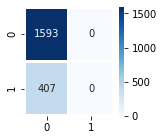

In [68]:
plot_confusion_matix(grid, bank_features_test.values, bank_labels_test)

##### Accuracy

Accuracy on the testing data is 79.65% - the same as that attained on the training set.

In [69]:
score = accuracy_score(bank_labels_test, pred)
score

0.7965

##### Classification report

The classification report prints precision, recall and f1 score for all classes, and accuracy for the whole dataset. The figures below confirm the model couldn't recognise cases when a bank client is closing his or her account. Thus, accuracy of almost 80% does not reveal the hidden problems of the model, namely it's inability to properly predict a given outcome.

In [70]:
print(classification_report(bank_labels_test, pred, zero_division = 0))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1593
           1       0.00      0.00      0.00       407

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.63      0.80      0.71      2000



Two other algorithms were tried and tested to remedy this failure. Their implementation is presented below. 

## V. Build and Train a model with ensemble algorithms

### 1. Random Forest

The first step is to prepare f1 as a scoring metric for placing in the GridSearchCV algorthm.

In [71]:
f1 = make_scorer(f1_score , average = "weighted")

`RandomForestClassifier()` has several hyper-parameters. The most important ones are the number of estimators (trees) and their maximum depth. These are stored in a dictionary with a range of values. Grid Search should find the combination returning the highest f1 score and the lowest error rate.

In [72]:
rf_params = {
    "n_estimators": [10, 15, 20, 25, 30],
    "max_depth": [6, 8, 10, 12, 14]
}

In [73]:
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state = 42), param_grid = rf_params, scoring = f1, cv = 5)

In [74]:
rf_grid_search.fit(bank_features_train, bank_labels_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

The best combination of hyper-parameters are 30 estimators 12 nodes deep.

In [75]:
rf_grid_search.best_params_

{'max_depth': 12, 'n_estimators': 30}

These figures are provided to the algorithm.

In [76]:
random_forest = RandomForestClassifier(n_estimators = 30, max_depth = 12)

#### Model evaluation

To speed up and to simplify model evalutaion, "fit", "predict", and "score" are placed in a function. It returns model's accuracy and f1 score on the chosen dataset. 

In [77]:
def model_evaluate(estimator, features, labels):
    """
    Function: Evaluate model by "fit", "predict" and "score" values of an estimator.
    
    Parameters: estimator, features (X) and labels (y).
    
    Returns: model's performance measured in terms of accuracy and f1_score.
    """
    estimator.fit(features, labels)
    predictions = estimator.predict(features)
    
    print(f"Accuracy: {accuracy_score(labels, predictions)}")
    print(f"F1 score: {f1_score(labels, predictions, average = 'weighted')}")

##### Accuracy and f1 score

Accuracy and f1 score on the testing data are much higher than those reached by the previous model. This could be explained with the small amount of samples in the testing set and/or with the fact that they were easier for the estimator.

In [78]:
model_evaluate(random_forest, bank_features_train, bank_labels_train)

Accuracy: 0.92975
F1 score: 0.9247381840441562


In [79]:
model_evaluate(random_forest, bank_features_test, bank_labels_test)

Accuracy: 0.9775
F1 score: 0.9769983627400197


##### Confusion matrix

As earlier, all samples of class "0" are properly classified. On the other hand, only around 10% of class "1" were mistaken.

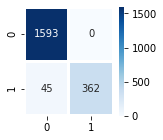

In [80]:
plot_confusion_matix(random_forest, bank_features_test, bank_labels_test)

##### Classification report

In [81]:
print(classification_report(bank_labels_test, random_forest.predict(bank_features_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1593
           1       1.00      0.89      0.94       407

    accuracy                           0.98      2000
   macro avg       0.99      0.94      0.96      2000
weighted avg       0.98      0.98      0.98      2000



### 2. Adaptive Boosting

The same computations were made with AdaBoost - a much stronger algorithm, described as a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases. It works with a base estimator, i.e., an algorithm which should be improved. Although Random Forest performed really well, it is interesting to see if AdaBoost would be able to lift the results up. Its "learning_rate" is tuned and number of estimators are fine-tuned.

In [82]:
ada_params = {
    "n_estimators": [10, 15, 20, 25],
    "learning_rate": [0.4, 0.6, 0.8, 1.0]
}

In [83]:
ada_grid = GridSearchCV(AdaBoostClassifier(RandomForestClassifier(n_estimators = 20, max_depth = 10)), param_grid = ada_params, scoring = f1, cv = 5)

In [84]:
ada_grid.fit(bank_features_train, bank_labels_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=RandomForestClassifier(bootstrap=True,
                                                                                ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=10,
                                                                                max_features='auto',
                                                                                max_leaf_nodes=None,
                                                                                max_samples=None,
                                                                                min_impurity_decrease=0.0,
            

Grid Search suggests an AdaBoost of 10 estimators trained with learning rate of 0.4 will return the highest accuracy. Random Forest is used with the hyper-parameters found earlier to perform best.

In [85]:
ada_grid.best_params_

{'learning_rate': 0.4, 'n_estimators': 10}

In [86]:
ada = AdaBoostClassifier(RandomForestClassifier(n_estimators = 20, max_depth = 10, random_state = 42), 
                         n_estimators = 10, learning_rate = 0.4)

#### Model evaluation

##### Accuracy and f1 score

AdaBoost returns slightly higher accuracy and f1 score on the testing data than Random Forest alone.

In [87]:
model_evaluate(ada, bank_features_train, bank_labels_train)

Accuracy: 0.9395
F1 score: 0.9360715591596271


In [88]:
model_evaluate(ada, bank_features_test, bank_labels_test)

Accuracy: 0.995
F1 score: 0.9949767277504842


##### Confusion matrix

This time, only 10 samples of class "1" are misclassified.

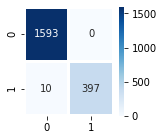

In [89]:
plot_confusion_matix(ada, bank_features_test, bank_labels_test)

##### Classification report

Better performace is visible in the Classification report, too.

In [90]:
print(classification_report(bank_labels_test, ada.predict(bank_features_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1593
           1       1.00      0.98      0.99       407

    accuracy                           0.99      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      0.99      0.99      2000



## Conclusion

To sum up, although accuracy is the most widely used success metric for classification tasks, it is far from perfect. High accuracy, especially on disbalanced and/or small datasets, might hide model problems such as inability to predict a under-represented class. And lastly, Neural Networks could be really powerful algorithms but sometimes, especially for smaller datasets, standard estimators such as Decision Trees and Random Forests, are preferred.